# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./data/train.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

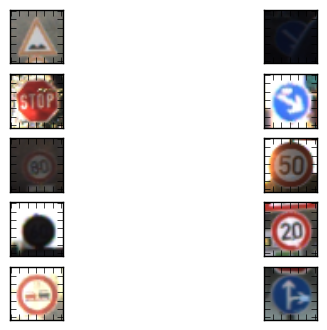

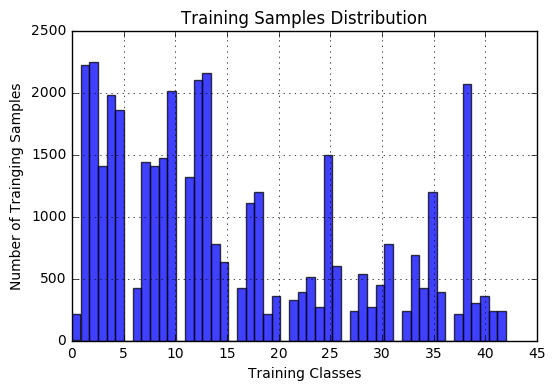

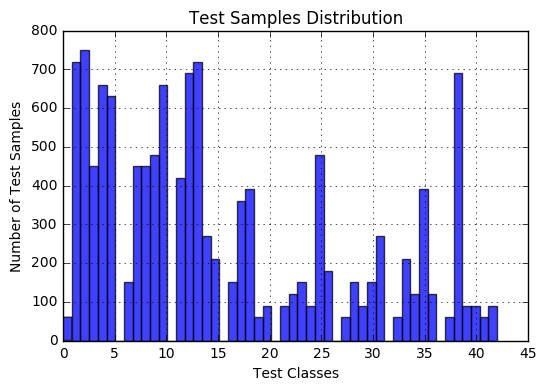

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
indx = np.arange(y_train.shape[0])
# shuffle the indices
np.random.shuffle(indx)
# create subplot and fill with images
f, axarr = plt.subplots(5, 2)
for i in range(5):
    for j in range(2):
        axarr[i, j].imshow(X_train[indx[j+5*i]])
        plt.setp(axarr[i,j].get_xticklabels(), visible=False)
        plt.setp(axarr[i,j].get_yticklabels(), visible=False)
plt.show()

# Show the distribution of classes in the training and test sets
# the histogram of the data
plt.figure(1)
n, bins, patches = plt.hist(y_train, 50, alpha=0.75)

plt.xlabel('Training Classes')
plt.ylabel('Number of Trainging Samples')
plt.title('Training Samples Distribution')
plt.grid(True)

plt.figure(2)
n, bins, patches = plt.hist(y_test, 50, alpha=0.75)

plt.xlabel('Test Classes')
plt.ylabel('Number of Test Samples')
plt.title('Test Samples Distribution')
plt.grid(True)

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
import time
from tqdm import tqdm
from six.moves import cPickle as pickle
import os
import cv2
from sklearn.cross_validation import train_test_split

pixel_depth = 255.0

def preprocess(image):
    image = image.astype(float)
    return (image-pixel_depth/2)/pixel_depth

def preprocess_batch(images):
    imgs = np.copy(images)
    for i in tqdm(range(images.shape[0])):
        imgs[i] = preprocess(images[i])
    return imgs

X_train_processed = preprocess_batch(X_train.astype(float))
X_test_processed = preprocess_batch(X_test.astype(float))


# We will use 80% for training and 20% for validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train_processed, 
                                                                y_train, 
                                                                test_size=0.20, 
                                                                random_state=42)

#Make sure all the sets line up and print shapes.
assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))



100%|██████████| 12630/12630 [00:00<00:00, 13670.17it/s]



Image Shape: (32, 32, 3)

Training Set:   31367 samples
Validation Set: 7842 samples
Test Set:       12630 samples


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [5]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

# Hyperparameters
batch_size = 50
map1 = 32
map2 = 64
num_fc1 = 700 #1028
num_fc2 = 43
reduce1x1 = 16
dropout = 0.75
model_name = 'inception_dropout'



def createWeight(size,Name):
    return tf.Variable(tf.truncated_normal(size, stddev=0.1),
                      name=Name)

def createBias(size,Name):
    return tf.Variable(tf.constant(0.1,shape=size),
                      name=Name)

def conv2d_s1(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def max_pool_3x3_s1(x):
    return tf.nn.max_pool(x,ksize=[1,3,3,1],
                         strides=[1,1,1,1],padding='SAME')


#Inception Module 1
#
#follows input
W_conv1_1x1_1 = createWeight([1,1,3,map1],'W_conv1_1x1_1')
b_conv1_1x1_1 = createWeight([map1],'b_conv1_1x1_1')

#follows input
W_conv1_1x1_2 = createWeight([1,1,3,reduce1x1],'W_conv1_1x1_2')
b_conv1_1x1_2 = createWeight([reduce1x1],'b_conv1_1x1_2')

#follows input
W_conv1_1x1_3 = createWeight([1,1,3,reduce1x1],'W_conv1_1x1_3')
b_conv1_1x1_3 = createWeight([reduce1x1],'b_conv1_1x1_3')

#follows 1x1_2
W_conv1_3x3 = createWeight([3,3,reduce1x1,map1],'W_conv1_3x3')
b_conv1_3x3 = createWeight([map1],'b_conv1_3x3')

#follows 1x1_3
W_conv1_5x5 = createWeight([5,5,reduce1x1,map1],'W_conv1_5x5')
b_conv1_5x5 = createBias([map1],'b_conv1_5x5')

#follows max pooling
W_conv1_1x1_4= createWeight([1,1,3,map1],'W_conv1_1x1_4')
b_conv1_1x1_4= createWeight([map1],'b_conv1_1x1_4')



#Inception Module 2
#
#follows inception1
W_conv2_1x1_1 = createWeight([1,1,4*map1,map2],'W_conv2_1x1_1')
b_conv2_1x1_1 = createWeight([map2],'b_conv2_1x1_1')

#follows inception1
W_conv2_1x1_2 = createWeight([1,1,4*map1,reduce1x1],'W_conv2_1x1_2')
b_conv2_1x1_2 = createWeight([reduce1x1],'b_conv2_1x1_2')

#follows inception1
W_conv2_1x1_3 = createWeight([1,1,4*map1,reduce1x1],'W_conv2_1x1_3')
b_conv2_1x1_3 = createWeight([reduce1x1],'b_conv2_1x1_3')

#follows 1x1_2
W_conv2_3x3 = createWeight([3,3,reduce1x1,map2],'W_conv2_3x3')
b_conv2_3x3 = createWeight([map2],'b_conv2_3x3')

#follows 1x1_3
W_conv2_5x5 = createWeight([5,5,reduce1x1,map2],'W_conv2_5x5')
b_conv2_5x5 = createBias([map2],'b_conv2_5x5')

#follows max pooling
W_conv2_1x1_4= createWeight([1,1,4*map1,map2],'W_conv2_1x1_4')
b_conv2_1x1_4= createWeight([map2],'b_conv2_1x1_4')



#Fully connected layers
#since padding is same, the feature map with there will be 4 32*32*map2
W_fc1 = createWeight([32*32*(4*map2),num_fc1],'W_fc1')
b_fc1 = createBias([num_fc1],'b_fc1')

W_fc2 = createWeight([num_fc1,num_fc2],'W_fc2')
b_fc2 = createBias([num_fc2],'b_fc2')


   
def model(x, dropout): 
    #Inception Module 1
    conv1_1x1_1 = conv2d_s1(x,W_conv1_1x1_1)+b_conv1_1x1_1
    conv1_1x1_2 = tf.nn.relu(conv2d_s1(x,W_conv1_1x1_2)+b_conv1_1x1_2)
    conv1_1x1_3 = tf.nn.relu(conv2d_s1(x,W_conv1_1x1_3)+b_conv1_1x1_3)
    conv1_3x3 = conv2d_s1(conv1_1x1_2,W_conv1_3x3)+b_conv1_3x3
    conv1_5x5 = conv2d_s1(conv1_1x1_3,W_conv1_5x5)+b_conv1_5x5
    maxpool1 = max_pool_3x3_s1(x)
    conv1_1x1_4 = conv2d_s1(maxpool1,W_conv1_1x1_4)+b_conv1_1x1_4

    #concatenate all the feature maps and hit them with a relu
    inception1 = tf.nn.relu(tf.concat(3,[conv1_1x1_1,conv1_3x3,conv1_5x5,conv1_1x1_4]))


    #Inception Module 2
    conv2_1x1_1 = conv2d_s1(inception1,W_conv2_1x1_1)+b_conv2_1x1_1
    conv2_1x1_2 = tf.nn.relu(conv2d_s1(inception1,W_conv2_1x1_2)+b_conv2_1x1_2)
    conv2_1x1_3 = tf.nn.relu(conv2d_s1(inception1,W_conv2_1x1_3)+b_conv2_1x1_3)
    conv2_3x3 = conv2d_s1(conv2_1x1_2,W_conv2_3x3)+b_conv2_3x3
    conv2_5x5 = conv2d_s1(conv2_1x1_3,W_conv2_5x5)+b_conv2_5x5
    maxpool2 = max_pool_3x3_s1(inception1)
    conv2_1x1_4 = conv2d_s1(maxpool2,W_conv2_1x1_4)+b_conv2_1x1_4

    #concatenate all the feature maps and hit them with a relu
    inception2 = tf.nn.relu(tf.concat(3,[conv2_1x1_1,conv2_3x3,conv2_5x5,conv2_1x1_4]))

    #flatten features for fully connected layer
    inception2_flat = tf.reshape(inception2,[-1,32*32*4*map2])

    #Fully connected layers, w/ dropout

    h_fc1 =tf.nn.dropout(tf.nn.relu(tf.matmul(inception2_flat,W_fc1)+b_fc1),dropout)

        
    #Layer2
    logits = tf.matmul(h_fc1,W_fc2)+b_fc2

    return logits

## Features and Labels

In [6]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline

In [7]:
rate = 0.001

logits = model(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation

In [8]:
#The correct_prediction line works with softmax output.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model

In [9]:
EPOCHS = 10
BATCH_SIZE = 128



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout })
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, model_name)
    print("Model saved")

ResourceExhaustedError: OOM when allocating tensor with shape[262144,700]
	 [[Node: W_fc1/Adam_1/Assign = Assign[T=DT_FLOAT, _class=["loc:@W_fc1"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](W_fc1/Adam_1, zeros_49)]]

Caused by op 'W_fc1/Adam_1/Assign', defined at:
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-08f4e4cd7a11>", line 7, in <module>
    training_operation = optimizer.minimize(loss_operation)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 279, in minimize
    name=name)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 393, in apply_gradients
    self._create_slots(var_list)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/training/adam.py", line 120, in _create_slots
    self._zeros_slot(v, "v", self._name)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 593, in _zeros_slot
    named_slots[var] = slot_creator.create_zeros_slot(var, op_name)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 108, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 86, in create_slot
    return _create_slot_var(primary, val, scope)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 50, in _create_slot_var
    slot = variables.Variable(val, name=scope, trainable=False)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 224, in __init__
    expected_shape=expected_shape)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 360, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[262144,700]
	 [[Node: W_fc1/Adam_1/Assign = Assign[T=DT_FLOAT, _class=["loc:@W_fc1"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](W_fc1/Adam_1, zeros_49)]]


## Test the Model
This is the final test performed on held out test set.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

started at 4:54

When using the non-processed set, the validation accuracy was 82.<br>
When using the processed set, the validation accuracy was 83.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.